
<img src="https://www.commonwealthfund.org/sites/default/files/prescription-drug-prices-binding-arbitration_21x9.jpg" alt="drawing" width="3000" height="100"/>

## Table of Contents

  1. <a href='#load'>Loading libraries and tha data</a>
  2. [Data Preparation](#prep)
      - [Data size and structure of the drug dataset](#structure)
      - [Changing features from categorical to numerical](#numeric)
  3. [Learning Curves](#learningcurve)
  4. [Feature Importance](#feature)
      - [Visualization](#vis)
  5. [Data Splitting](#split)
  6. [Random Forest Classification](#rfc)
  7. [Hyperparameter Tuning](#ht)
      - [Random Search](#random)
      - [Grid Search](#grid)
      - [Comparison](#comparison)
      
  

<a id='load'></a>

## Loading libraries and tha data

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv("kaggle/drug_classification/drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


<a id='prep'></a>

## Data Preparation 

<a id='structure'></a>
### Data size and structure of the drug dataset

In [116]:
df.shape

(200, 6)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [26]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [27]:
df.nunique()

Age             57
Sex              2
BP               3
Cholesterol      2
Na_to_K        198
Drug             5
dtype: int64

In [29]:
df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

<AxesSubplot:xlabel='Drug', ylabel='count'>

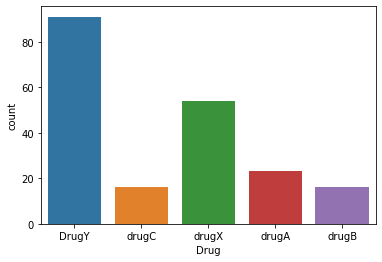

In [141]:
sns.countplot(df['Drug'])

With this preliminary analysis, we observed that this dataset consists 5 different drug types and data from 200 patients. The data does not contain any null values. We have 4 different features and 3 of them are categorical (Sex, BP and Cholesterol). So the next step is to change these 3 fetaures from categorical to numerical.  
<a id='numeric'></a>

In [35]:
df_n = pd.get_dummies(df,columns=['Sex','BP','Cholesterol'])
drug_numeric = {'DrugY':1, 'drugC':2, 'drugX':3, 'drugA':4, 'drugB':5}
df_n['Drug'] = df_n['Drug'].map(drug_numeric)
df_n.head()

,Age,Na_to_K,Drug,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,1,1,0,1,0,0,1,0
1,47,13.093,2,0,1,0,1,0,1,0
2,47,10.114,2,0,1,0,1,0,1,0
3,28,7.798,3,1,0,0,0,1,1,0
4,61,18.043,1,1,0,0,1,0,1,0


In [32]:
df_n.columns

Index(['Age', 'Na_to_K', 'Drug', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW',
       'BP_NORMAL', 'Cholesterol_HIGH', 'Cholesterol_NORMAL'],
      dtype='object')

<a id='learningcurve'></a>
## Learning Curves

In [51]:
train_sizes = [1, 10, 50, 100, 160]

features = ['Age', 'Na_to_K', 'Sex_F', 'Sex_M','BP_HIGH', 'BP_LOW',
       'BP_NORMAL', 'Cholesterol_HIGH', 'Cholesterol_NORMAL']
target = 'Drug'

X = df_n[features]
y = df_n[target]

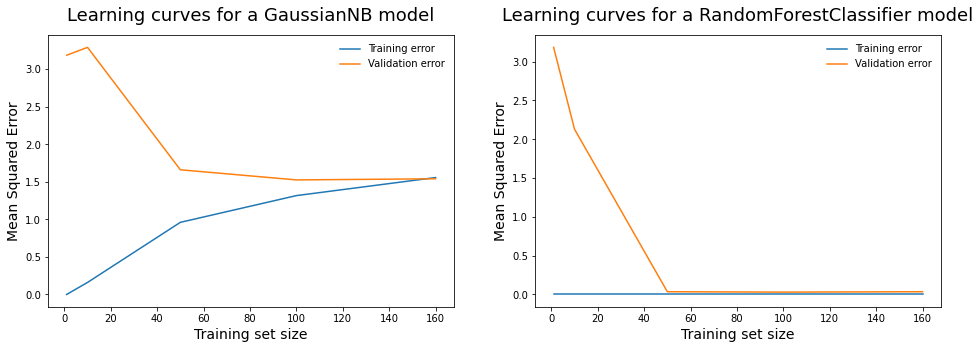

In [193]:
def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Mean Squared Error', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend(frameon=False)

plt.figure(figsize = (16,5))

for model, i in [(GaussianNB(),1), (RandomForestClassifier(), 2)]:
    plt.subplot(1,2,i)
    learning_curves(model,df_n, features, target, train_sizes, 5)
plt.show()

As it can be seen from learning curves, Random Forest works uch better than Naive Bayes with our data. Random Forest Classifier method has both low varience and low training error and it predicts well with even small data (>50).


<a id='feature'></a>
## Feature Importance

In [65]:
bfeat = SelectKBest(score_func=f_regression, k=9) 
fit = bfeat.fit(X,y)
bf = pd.DataFrame(data={'Features':features, 'Scores':fit.scores_})
bf.sort_values(by=['Scores'],ascending=False)

,Features,Scores
1,Na_to_K,169.775879
4,BP_HIGH,14.250968
5,BP_LOW,12.103374
0,Age,2.732420
2,Sex_F,1.413302
3,Sex_M,1.413302
7,Cholesterol_HIGH,0.761456
8,Cholesterol_NORMAL,0.761456
6,BP_NORMAL,0.190120


In [69]:
model = RandomForestRegressor()
model.fit(X,y)
model_bf = pd.DataFrame(data={'Features':features, 'Scores':model.feature_importances_})
model_bf.sort_values(by=['Scores'],ascending=False)

,Features,Scores
1,Na_to_K,0.754585
4,BP_HIGH,0.185232
0,Age,0.025319
8,Cholesterol_NORMAL,0.010499
6,BP_NORMAL,0.010176
5,BP_LOW,0.007326
7,Cholesterol_HIGH,0.006863
2,Sex_F,0.000000
3,Sex_M,0.000000


<a id='vis'></a>
### Visualization 

Text(0.5, 0, 'Scores')

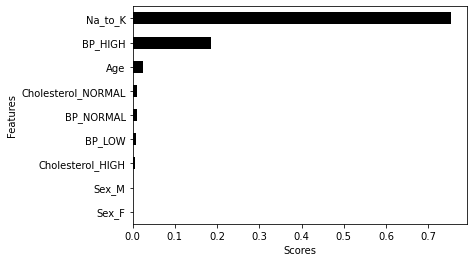

In [93]:
model_bf.sort_values(by=['Scores'],ascending=True).plot(x='Features', y='Scores',kind='barh', color= 'k',rot=0, legend= False)
plt.xlabel('Scores')


<a id='split'></a>
## Data Splitting

- Number of samples are not balanced for different types of drugs so we use `stratify` to keep the same ratio for the sets.
- From the learning curve we know that 50 sample was enough for the training set, so we will use 100 for test set and 100 for training set for now

In [96]:
#50% training, 50% test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4, stratify=y)


Text(0.5, 1.0, 'Training Set')

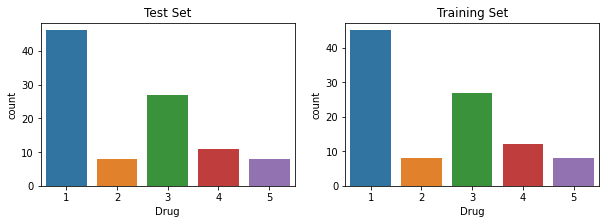

In [142]:
plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
sns.countplot(y_test)
plt.title('Test Set')
plt.subplot(1,2,2)
sns.countplot(y_train)
plt.title('Training Set')

<a id='rfc'></a>
## Random Forest Classification

In [186]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.03 degrees.


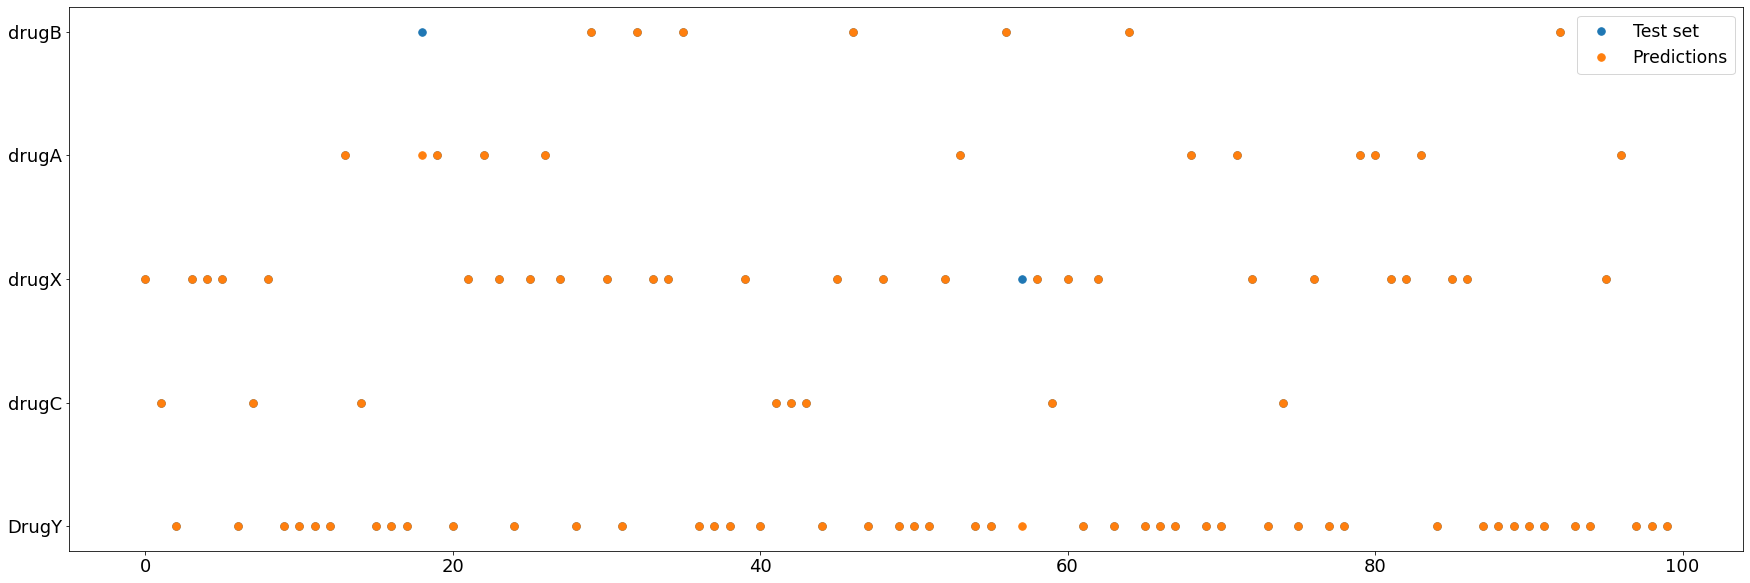

In [190]:
plt.figure(figsize = (30,10))
plt.plot(np.arange(len(y_test)),y_test, marker='.',lw=0,markersize=15, label='Test set')
plt.plot(predictions, marker='.',lw=0,markersize=15, label='Predictions')
# plt.ylabel("Drugs", fontsize=20)
plt.yticks(np.arange(1,6),['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize='xx-large')
plt.show()

<a id='ht'></a>
## Hyperparameter Tuning

### Random Search
<a id='random'></a>
Creating the random grid:

In [118]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree
random_search = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_search)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [119]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_search, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train)# Fit the random search model


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Best Parameters:

In [120]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

### Grid Search
<a id='grid'></a>
Creating the parameter grid based on the results of random search:

In [123]:
grid_params = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1800, 2000, 2200, 2400]
}
grid_search = GridSearchCV(estimator = rf, param_grid = grid_params, 
                          cv = 3, n_jobs = -1, verbose = 2)
print(grid_search)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1800, 2000, 2200, 2400]},
             verbose=2)


In [124]:
grid_search.fit(x_train, y_train) # Fit the grid search model

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 31.5min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1800, 2000, 2200, 2400]},
             verbose=2)

Best Parameters:

In [125]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 1800}

<a id='comparison'></a>
### Comparison

In [136]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mean_error = np.mean(errors)
    print('Model Performance:  '+str(model))
    print('Average Error: {:0.4f} degrees.'.format( mean_error))
    return mean_error

- Base Model

In [187]:
base_model = RandomForestClassifier()
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance:  RandomForestClassifier()
Average Error: 0.0300 degrees.


- Random Search

In [138]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

Model Performance:  RandomForestRegressor(bootstrap=False, max_depth=30, min_samples_leaf=4,
                      n_estimators=2000)
Average Error: 0.0300 degrees.


- Grid Search

In [139]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)

Model Performance:  RandomForestRegressor(bootstrap=False, max_depth=50, max_features=3,
                      min_samples_leaf=3, min_samples_split=3,
                      n_estimators=1800)
Average Error: 0.2320 degrees.


In [189]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        46
           2       1.00      1.00      1.00         8
           3       1.00      0.96      0.98        27
           4       0.92      1.00      0.96        11
           5       1.00      0.88      0.93         8

    accuracy                           0.98       100
   macro avg       0.98      0.97      0.97       100
weighted avg       0.98      0.98      0.98       100



In [195]:
print("Number of mislabeled points out of a total %d points : %d"% (x_test.shape[0], (y_test != predictions).sum()))

Number of mislabeled points out of a total 100 points : 2
